In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.cross_validation import train_test_split
from scipy.stats.stats import pearsonr
from itertools import combinations_with_replacement

from collections import defaultdict

In [2]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

### Cleaning review information

In [3]:
reviews = pd.read_csv('../data/all_reviews.csv',sep='\t',encoding='utf-8', index_col=0)
users = pd.read_csv('../data/all_users.csv',sep='\t',encoding='utf-8', index_col=0)
reviews.animation = reviews.animation.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.character = reviews.character.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.overall = reviews.overall.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.sound = reviews.sound.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.story = reviews.story.str.strip().str[0:-3].convert_objects(convert_numeric=True)

### Cleaning user information

In [4]:
for i in users.index:
    temp = users.ix[i,'age_sex'].strip().split('/')
    age = '?'
    sex = '?'
    
    # check if user has provided age/sex
    if len(temp)==2:
        age = temp[0]
        sex = temp[1]  
    elif temp[0].isdigit():
        age = temp[0]
    else:
        sex = temp[0]
        
    users.ix[i,'age']=age
    users.ix[i,'sex']=sex

In [5]:
# remove those without age/sex
subusers = users.loc[(users.age!='? ')&(users.sex!='?')]
print subusers.shape
subusers.head()

,age_sex,join,place,age,sex
0Marcandre,20 / M,"Joined Mar 31, 2013",NaN,20,M
11bowman,21 / M,"Joined Jun 19, 2010","Amsterdam, Netherlands",21,M
11sam1234,21 / F,"Joined Nov 20, 2008",alto,21,F
29ActiveDownloads,20 / M,"Joined Apr 26, 2011",NaN,20,M
2minion,20 / F,"Joined Aug 2, 2013",NaN,20,F


### Combining users with review information

In [12]:
# remove reviews whose user is not in user database
mask = [i in subusers.index for i in reviews.name]
subreviews = reviews.loc[mask]

In [15]:
# match age and sex info to reviews
age = []
sex = []

for i in subreviews.index:
    age.append(int(subusers.ix[subreviews.ix[i,'name'],'age']))
    sex.append(subusers.ix[subreviews.ix[i,'name'],'sex'])
    
subreviews.loc[:,'age']=age
subreviews.loc[:,'sex']=sex

subreviews.head()

,animation,anime,anime_name,character,name,overall,reviews,sound,story,age,sex
0,10,to-aru-majutsu-no-index-10th-anniversary-pv,To Aru Majutsu no Index 10th Anniversary PV,10,SogiitaGunhaGUTS,10.0,Well it's a short animation to celebrate Kamac...,NaN,NaN,15,M
1,5,dokkoida,Dokkoida?!,6,angelsreviews,5.0,NaN,5,8,26,F
2,9,inazuma-eleven,Inazuma Eleven,9,xxjacobxx3,9.0,first of all: I agree with ﻿﻿﻿﻿luminex's revie...,9,9,25,M
4,8,brigadoon-marin-to-melan,Brigadoon Marin to Melan,8,roriconfan,8.0,NaN,9,8,34,M
5,7,brigadoon-marin-to-melan,Brigadoon Marin to Melan,9,KiraRin,8.5,NaN,7,8,33,F


In [17]:
subusers.head()

,age_sex,join,place,age,sex
0Marcandre,20 / M,"Joined Mar 31, 2013",NaN,20,M
11bowman,21 / M,"Joined Jun 19, 2010","Amsterdam, Netherlands",21,M
11sam1234,21 / F,"Joined Nov 20, 2008",alto,21,F
29ActiveDownloads,20 / M,"Joined Apr 26, 2011",NaN,20,M
2minion,20 / F,"Joined Aug 2, 2013",NaN,20,F


In [ ]:
mean_age = subreviews.age.mean()

age = []
sex = []

final = reviews.copy()

for i in final.index:
    name = final.ix[i,'name']
    if name in subusers.index:
        age.append(int(subusers.ix[name,'age']))
        sex.append(subusers.ix[name,'sex'].strip())
    else:
        age.append(mean_age)
        ran = np.random.random_integers(0,high=1)
        if ran==1:
            sex.append('M')
        else:
            sex.append('F')
        
    
final.loc[:,'age']=age
final.loc[:,'sex']=sex

final.head()

In [ ]:
for i,val in enumerate(final.anime_name):
    if val == 'Beyblade: G Revolution':
        final.ix[i,'anime_name']='Beyblade G Revolution'
    if val == 'Beyblade: V-Force':
        final.ix[i,'anime_name']='Beyblade V-Force'
    if val == 'Beyblade: The Movie':
        final.ix[i,'anime_name']='Beyblade - The Movie'

### Adding in more features

In [ ]:
data=pd.read_csv("../data/anime_info.csv",sep='\t', index_col=0)
anime_name = pd.read_csv('../data/anime_name.csv',sep='\t',encoding='utf-8', index_col=0)
data.head()

In [ ]:
names = []
for i in data.index:
    names.append(i.encode('ascii', 'ignore'))
data.index=names

In [ ]:
# checking how many unique categories
genres = data.categories.tolist()

temp = []
for i in genres:
    if type(i)==str:
        temp+=i.replace('[','').replace(']','').replace(' ','').split(',')
uniq_genres = list(set(temp))
len(uniq_genres)

In [ ]:
# changing categories from string to list
temp = []
genres = data.categories.tolist()
for i in genres:
    if type(i)==str:
        temp.append(i.replace('[','').replace(']','').replace(' ','').split(','))
    else:
        temp.append([])
data.loc[:,'categories_list'] = temp

In [ ]:
# finding categories
categories = defaultdict(list)
for i in final.anime_name:
    cat = data.loc[i.encode('ascii', 'ignore'),'categories_list']
    for j in cat:
        categories[j].append(1)
    for k in uniq_genres:
        if k not in cat:
            categories[k].append(0)
            
# add categories to final
for i in categories:
    final.loc[:,i] = categories[i]

In [ ]:
per = final.shape[0]*0.005
print (final.ix[:,11:].sum(axis=0)>per).sum()
mask = (final.ix[:,11:].sum(axis=0)>per)

In [ ]:
for i in final.columns[11:]:
    check = mask[i]
    if not check:
        final.drop(i,axis=1,inplace=True)

In [ ]:
final.to_csv('../data/final_review.csv')

### Data

In [2]:
final = pd.read_csv('../data/final_review.csv',index_col=0)

In [3]:
ratings = ['animation','character','overall','sound','story']
for i in ratings:
    mean = final.ix[:,i].mean()
    final.ix[:,i].fillna(mean,inplace=True)

In [4]:
# in case of repeats
print final.shape
final=final.drop_duplicates(['anime','name'])
print final.shape

(17194, 141)
(17194, 141)


In [17]:
# calculating biases for user, anime, sex, and age
user_biases = dict()
for i,val in final.groupby('name'):
    user_biases[i] = np.mean(val.overall)-ybar

anime_biases = dict()
for i,val in final.groupby('anime'):
    anime_biases[i] = np.mean(val.overall)-ybar
    
sex_biases = dict()
for i,val in final.groupby('sex'):
    sex_biases[i] = np.mean(val.overall)-ybar
    
age_biases = dict()
for i,val in final.groupby('age'):
    age_biases[i] = np.mean(val.overall)-ybar

In [74]:
user_avgs = []
overall_y_bar = final.overall.mean()
for i in final.name:
    user_avgs.append(user_biases[i]+overall_y_bar)
    
final.loc[:,'user_avgs'] = user_avgs

User review counts mean and median 3.85342895563 1.0


(0, 20)

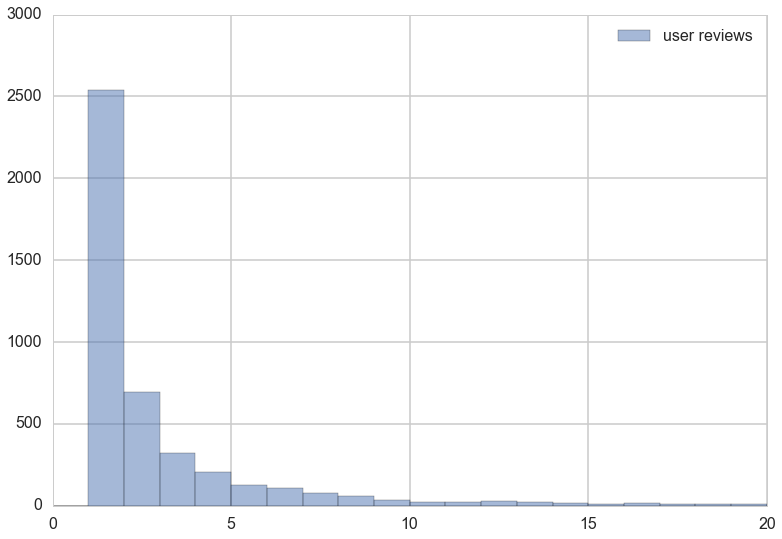

In [76]:
c=final.groupby('name').anime.count()
print "User review counts mean and median",np.mean(c), np.median(c)
plt.hist(c, bins=np.arange(50), alpha=0.5, label="user reviews");
plt.legend();
plt.xlim([0,20])

In [77]:
# sort animes with more than one review
# anime_vc = final.anime.value_counts()
# sub_reviews = final[final.anime.isin(anime_vc[anime_vc > 10].index)]

# splitting into train, test, and validate
train, test = train_test_split(final,train_size=0.5,test_size=0.5)
validate, test = train_test_split(test,train_size=0.5,test_size=0.5)

In [78]:
train.shape,test.shape

((8597, 142), (4299, 142))

In [79]:
ybar = train.overall.mean()
ybar

7.1700418750727355

In [80]:
# mapping of userid and anime
uuids=train.name.unique()#unique-user-ids
uiids=train.anime.unique()#unique-item-ids

uuidmap={v:k for k,v in enumerate(uuids)}#of length U
uiidmap={v:k for k,v in enumerate(uiids)}#of length M

In [81]:
final.head()

,animation,anime,anime_name,character,name,overall,reviews,sound,story,age,sex,Trains,BoardingHouse,Political,Demons,BasedonaLightNovel,Supernatural,Comedy,BountyHunters,Harem,EmotionalAbuse,Androids,Robots,Mecha,Western,Ninja,Thriller,Adventure,LoveTriangle,Magic,RPG,Violence,Shinigami,Military,Sports,Parody,TimeTravel,Aliens,JapaneseMythology,ReverseHarem,Cyberpunk,Swordplay,ClassicalMusic,Detectives,FeudalJapan,Romance,Terrorism,Tournaments,MagicalGirl,PantyShots,...,Mercenaries,PersoninaStrangeWorld,FoodandBeverage,Vampires,Cyborgs,Incest,Shoujo-ai,MMORPG,LGBTThemes,noitaminA,Abstract,SuddenGirlfriendAppearance,Monster-of-the-week,Mystery,OriginalWork,Police,WorkLife,PsychicPowers,Maids,PlayorDie,Chibi,Dystopia,Psychological,HandtoHandCombat,Crude,Angels,SliceofLife,BasedonaVisualNovel,ExplicitSex,Shorts,Survival,OuterSpace,CGAnimation,Master-ServantRelationship,ExplicitViolence,Assassins,MatureThemes,Josei,MartialArts,America,BasedonanOtomeGame,Gunfights,Samurai,ComingofAge,AnimalAbuse,Fantasy,PhysicalAbuse,SchoolLife,Ecchi,user_avgs
0,10,to-aru-majutsu-no-index-10th-anniversary-pv,To Aru Majutsu no Index 10th Anniversary PV,10,SogiitaGunhaGUTS,10,Well it's a short animation to celebrate Kamac...,7.620556,6.811945,15.00000,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.999651
1,5,dokkoida,Dokkoida?!,6,angelsreviews,5,NaN,5.000000,8.000000,26.00000,F,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.206000
2,9,inazuma-eleven,Inazuma Eleven,9,xxjacobxx3,9,first of all: I agree with ﻿﻿﻿﻿luminex's revie...,9.000000,9.000000,25.00000,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.429196
3,8,inazuma-eleven,Inazuma Eleven,6,Lumineux,7,Story: 6,8.000000,6.000000,25.23511,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.153497
4,8,brigadoon-marin-to-melan,Brigadoon Marin to Melan,8,roriconfan,8,NaN,9.000000,8.000000,34.00000,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.014144


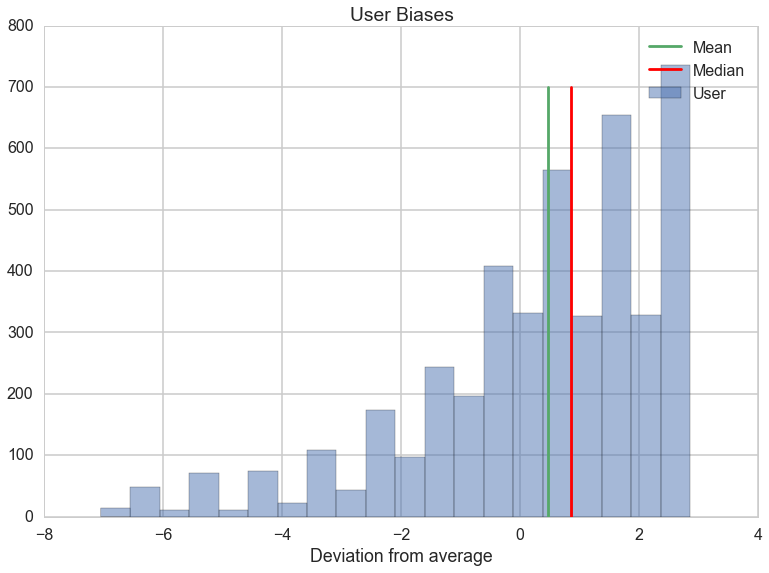

In [82]:
hist1 = plt.hist(user_biases.values(),alpha=0.5,bins=20,label='User')
plt.title('User Biases')
plt.xlabel("Deviation from average")
plt.plot([np.mean(user_biases.values()),np.mean(user_biases.values())],[0,700],label='Mean')
plt.plot([np.median(user_biases.values()),np.median(user_biases.values())],[0,700],color='r',label='Median')
plt.legend()

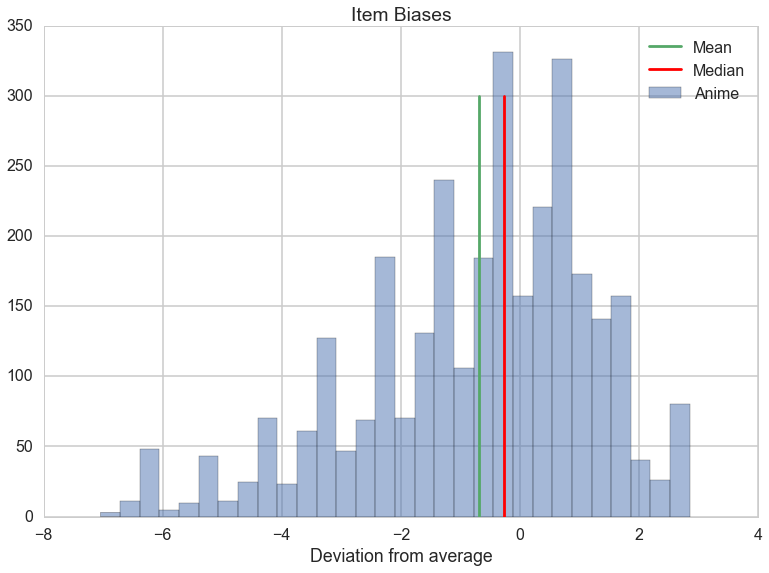

In [83]:
hist2 = plt.hist(anime_biases.values(),bins=30,alpha=0.5,label='Anime')
plt.title('Item Biases')
plt.xlabel("Deviation from average")
plt.plot([np.mean(anime_biases.values()),np.mean(anime_biases.values())],[0,300],label='Mean')
plt.plot([np.median(anime_biases.values()),np.median(anime_biases.values())],[0,300],color='r',label='Median')
plt.legend()

In [84]:
train_avgs={'mean':ybar, 'users':user_biases, 'animes':anime_biases, 'sex':sex_biases, 'age':age_biases}
predictions={}
predictions_valid={}

In [85]:
# saving user and anime biases in train and validate sets
# saving user and anime biases in train and validate sets
# predictions["baseline"] = [ybar+user_biases[i[1][4]]+anime_biases[i[1].anime] for i in test.iterrows()]
# predictions_valid['baseline'] = [ybar+user_biases[i[1][4]]+anime_biases[i[1].anime] for i in validate.iterrows()]

predictions["baseline"] = [ybar+user_biases[i[1][4]]+anime_biases[i[1].anime]+sex_biases[i[1].sex]+age_biases[i[1].age] for i in test.iterrows()]
predictions_valid['baseline'] = [ybar+user_biases[i[1][4]]+anime_biases[i[1].anime]+sex_biases[i[1].sex]+age_biases[i[1].age] for i in validate.iterrows()]


In [86]:
def get_rmse(s, s_predict):
    diff = np.subtract(s,s_predict)
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [87]:
def compare_results(stars_actual, stars_predicted, ylow=0, yhigh=10, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1, label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,10],[0,10], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        ax.set_xlim([0, 10])
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(stars_actual, stars_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

RMSE for baseline 1.74714144538


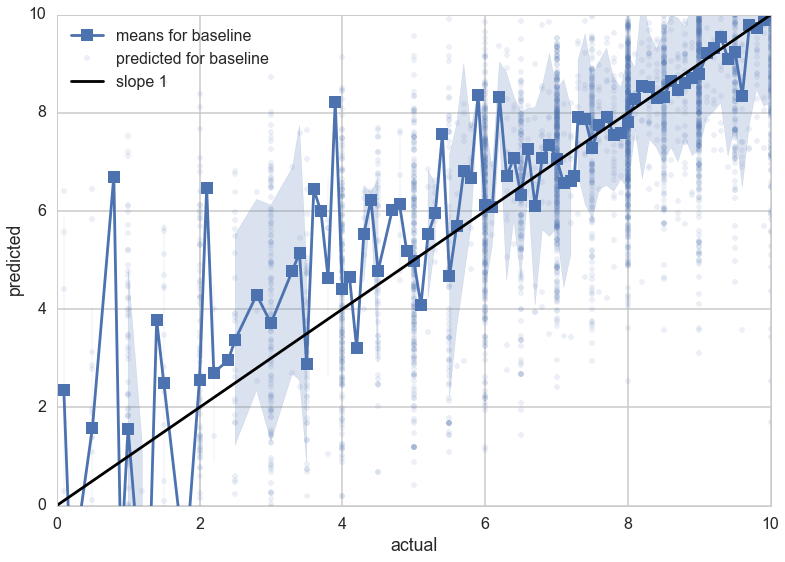

In [88]:
compare_results(test.overall.tolist(),predictions['baseline'], model="baseline", predicteds=True);

### Using kNN

In [89]:
train.groupby('anime')['name']

In [90]:
#for each restaurant get the unique userids who rated it
users_for_anime = train.groupby('anime')['name'].unique()
anime=uiids
lres=len(anime)
supports=[[[] for i in range(lres)] for i in range(lres)]
supporthistlist=[]
for i,an1 in enumerate(anime):
    for j,an2 in enumerate(anime):
        if  i <= j:#its symmetric
            if an1==an2:
                common_reviewers=users_for_anime[an1]
            else:
                common_reviewers = set(users_for_anime[an1]).intersection(set(users_for_anime[an2]))
                supporthistlist.append(len(common_reviewers))
            supports[i][j]=common_reviewers
            supports[j][i]=common_reviewers
print "Mean and Median support is:",np.mean(supporthistlist), np.median(supporthistlist)

Mean and Median support is: 0.0456825659982 0.0


In [97]:
"""
Given a subframe or dictionary of anime 1 reviews and a subframe or dictionary of anime 2 reviews, 
and the number of common reviewers n_common,
where the reviewers are those who have reviewed both anime, return 
the pearson correlation coefficient between the user average subtracted ratings.
The case for zero common reviewers is handled separately, return 0. If the correlation is
NaN if any of the individual variances are 0 (the n=1 case), return 0 instead.
"""
def pearson_sim(an1_reviews, an2_reviews, n_common):
    # When zero common reviewers
    if n_common==0:
        return 0

    # Else mean-center rest values
    an1_val = np.subtract(an1_reviews['overall'],an1_reviews['user_avgs'])
    an2_val = np.subtract(an2_reviews['overall'],an2_reviews['user_avgs'])

    # pearson correlation
    corr = pearsonr(an1_val,an2_val)
    
    # Return 0 when individual restaurant rating variance is 0

    if np.isnan(corr[0]) == False:
        return corr[0]
    else:
        return 0

In [92]:
def get_anime_reviews(anime, df, set_of_users):
    """
    given a anime and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.name.isin(set_of_users)) & (df.anime==anime)
    reviews = df[mask]
    reviews = reviews[reviews.name.duplicated()==False]
    return reviews

In [93]:
class Database:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, rindexmap, supports):
        "the constructor, takes a map of animes to integers"
        database={}
        self.rindexmap=rindexmap
        self.supports=supports
        l_keys=len(self.rindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)

    def set_supports(self, supports):
        self.supports=supports
        
    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two animes"
        sim=self.database_sim[self.rindexmap[b1]][self.rindexmap[b2]]
        nsup=self.database_sup[self.rindexmap[b1]][self.rindexmap[b2]]
        return (sim, nsup)

In [94]:
db=Database(uiidmap, supports)

In [99]:
def calculate_similarity(db, df, an1, an2, similarity_func):
    # find common reviewers
    common_reviewers = db.supports[db.rindexmap[an1]][db.rindexmap[an2]]
    n_common=len(common_reviewers)
    if an1==an2:
        return 1., n_common
    #get reviews
    an1_reviews = get_anime_reviews(an1, df, common_reviewers)
    an2_reviews = get_anime_reviews(an2, df, common_reviewers)
    sim=similarity_func(an1_reviews, an2_reviews, n_common)
    return sim, n_common

def populate_by_calculating(db, df, similarity_func):
    """
    a populator for every pair of businesses in df. takes similarity_func like
    pearson_sim as argument
    """
    items=db.rindexmap.items()
    for b1, i1 in items:
        for b2, i2 in items:
            if i1 <= i2:
                sim, nsup=calculate_similarity(db, df, b1, b2, similarity_func)
                db.database_sim[i1][i2]=sim
                db.database_sim[i2][i1]=sim
                db.database_sup[i1][i2]=nsup
                db.database_sup[i2][i1]=nsup

In [151]:
%%time
populate_by_calculating(db, train, pearson_sim)

CPU times: user 5h 18min 53s, sys: 2min 5s, total: 5h 20min 59s
Wall time: 5h 28min 58s


In [161]:
%%time
populate_by_calculating(db, validate, pearson_sim)

CPU times: user 3h 52min 23s, sys: 1min 1s, total: 3h 53min 24s
Wall time: 6h 21min 10s


/Users/dylantan/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [152]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

In [153]:
"""
Function
--------
knearest

Parameters
----------
anime : string
    The name of the anime whose nearest neighbors we want
set_of_animes : array
    The set of animes from which we want to find the nearest neighbors
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two animes. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
A sorted list
    of the top k similar animes. The list is a list of tuples
    (anime, shrunken <strong>distance</strong>, common support).
"""

from operator import itemgetter
def knearest(anime, set_of_animes, dbase, k=7, reg=3.):
    """
    Given a anime, dataframe, and database, get a sorted list of the
    k most similar animes from the set of anime.
    """
    similars=[]
    for other_anime in set_of_animes:
        if other_anime!=anime:
            sim, nc=dbase.get(anime, other_anime)
            ssim=shrunk_sim(sim, nc, reg=reg)
            simdist=(1. - ssim)/2.
            similars.append((other_anime, simdist, nc ))
    similars=sorted(similars, key=itemgetter(1))
    return similars[0:k]

In [154]:
def get_users_animes(df, user_id):
    dfuser=df[df.name==user_id]
    dfuserdedup=dfuser.drop_duplicates('anime')
    return dict(zip(dfuserdedup.anime.values, dfuserdedup.overall.values))

In [155]:
"""
Function
--------
rating

Parameters
----------
set_of_anime: Dictionary
    The dictionary of animes: overall-rating pairs you want to make the prediction from.
    This would be the output of a function like get_users_animes
train_map: Dictionary
    A dictionary with keys mean, users and items which have estimates of
    overall average or intercept, user coefficients(averages), and
    item coefficients(averages) respectively
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
anime : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A float
    which is the imputed rating that we predict that user_id will make for anime_id
    
Notes
--------
If the sum of scores is 0, return the baseline estimate of the ranking.
"""
def rating(set_of_animes,train_map,dbase,anime,user_id,age,sex,k,reg):
    # Get k nearest distance
    knear = knearest(anime,set_of_animes,dbase,k=k,reg=reg)
    
    sm_top = 0
    sm_bot = 0
    for i in knear:
        
        # Actual user rating
        Y_uj = final.loc[(final.name == user_id)&(final.anime==i[0])].overall.values[0]

        # User baseline rating
        Y_uj_base = train_map['mean']+train_map['users'][user_id]+train_map['animes'][i[0]]+train_map['age'][age]+train_map['sex'][sex]
        
        # Top and bottom of equation
        sm_top += (1-i[1])*(Y_uj-Y_uj_base)
        sm_bot += (1-i[1])
    
    # Return baseline if bottom is 0
    if sm_bot == 0:
        return predictions["baseline"][uuidmap[user_id]]

    return ybar+train_map['users'][user_id]+train_map['animes'][anime] +sm_top/sm_bot

In [157]:
trainuser=train.name.tolist()[0]
testrest=test[test.name==trainuser].anime.values[0]
testage=test[test.name==trainuser].age.values[0]
testsex=test[test.name==trainuser].sex.values[0]

print trainuser, testrest

def get_actual(df, userid, bizid):
    return df[(df.name==userid) & (df.anime==bizid)]['overall'].values[0]

print "Actual", get_actual(test, trainuser, testrest)
print "Predicted",rating(get_users_animes(train, trainuser), train_avgs, db, testrest, trainuser,testage,testsex, k=2, reg=3.)

LibertyX kara-no-kyoukai-satsujin-kousatsu
Actual 9.0
Predicted 9.41831952186


In [158]:
def get_ratings_user_nbd(indf, traindf, train_map, db, k=2, reg=3.):
    zips=zip(indf.anime, indf.name, indf.overall,indf.age,indf.sex)
    preds=[]
    actuals=[]
    for (r,u,actual,a,s) in zips:
        pred=rating(get_users_animes(traindf, u),train_map, db, r,u,a,s, k, reg)
        preds.append(pred)
        actuals.append(actual)
    return np.array(preds), np.array(actuals)

RMSE for knn(user) on training k=4, reg=4 2.3749921239


(<matplotlib.axes._subplots.AxesSubplot at 0x136486c10>, 2.3749921238967473)

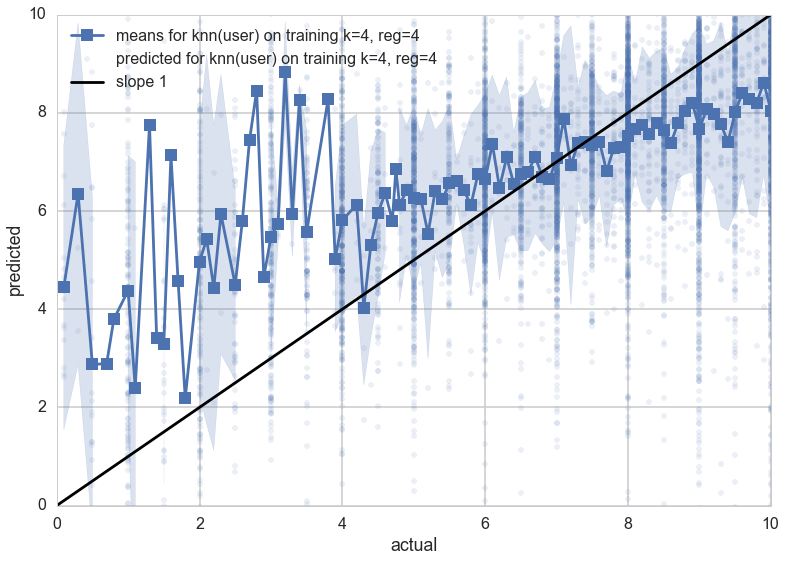

In [159]:
pt, at = get_ratings_user_nbd(train, train, train_avgs, db, k=4, reg=4.)
compare_results(at,pt, model="knn(user) on training k=4, reg=4", predicteds=True)

In [163]:
rmsedict = dict()
for k in np.arange(1,101,10):
    for reg in np.arange(1,101,10):
        pt, at = get_ratings_user_nbd(validate, validate, train_avgs, db, k=k, reg=reg)
        rmsedict[(k,reg)] = get_rmse(pt,at)

KeyError: 'da-capo-ii'

In [ ]:
mintup=min(rmsedict, key=rmsedict.get)
mintup

In [ ]:
for k in np.arange(mintup[0]-10,mintup[0]+10,5):
    for reg in np.arange(mintup[1]-10,mintup[1]+10,5):
        pt, at = get_ratings_user_nbd(validatedf, validatedf, train_avgs, db, k=k, reg=reg)
        rmsedict[(k,reg)] = get_rmse(pt,at)

In [ ]:
mintup=min(rmsedict, key=rmsedict.get)
mintup

In [ ]:
predictions['knn'],at = get_ratings_user_nbd(traindf, traindf, train_avgs, db, k=mintup[0], reg=float(mintup[1]))
predictions_valid['knn'],v_at = get_ratings_user_nbd(validatedf, validatedf, train_avgs, db, k=mintup[0], reg=float(mintup[1]))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

compare_results(at,predictions['knn'], model="knn(user) on optimized k and reg", predicteds=True, onsame=ax)
compare_results(testdf.stars,predictions['baseline'], model="baseline", predicteds=True, onsame=ax)